# Checking the performance of different models in the validation set
*Ana Maria Sousa, Mariana Xavier, Rui Santos*


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Read and load the train files

In [3]:
import numpy as np

files = np.load('/content/drive/MyDrive/resampled_train.npy')
train_files = [file[0] for file in files]
print(train_files)
print(len(train_files))

['Dog_1_interictal_segment_0387_channel_8.npy', 'Dog_1_interictal_segment_0410_channel_1.npy', 'Dog_1_interictal_segment_0416_channel_6.npy', 'Dog_1_interictal_segment_0139_channel_8.npy', 'Dog_1_interictal_segment_0079_channel_12.npy', 'Dog_1_interictal_segment_0145_channel_10.npy', 'Dog_1_interictal_segment_0206_channel_15.npy', 'Dog_1_interictal_segment_0291_channel_8.npy', 'Dog_1_interictal_segment_0412_channel_8.npy', 'Dog_1_interictal_segment_0050_channel_3.npy', 'Dog_1_interictal_segment_0271_channel_10.npy', 'Dog_1_interictal_segment_0079_channel_1.npy', 'Dog_1_interictal_segment_0445_channel_9.npy', 'Dog_1_interictal_segment_0185_channel_7.npy', 'Dog_1_interictal_segment_0386_channel_11.npy', 'Dog_1_interictal_segment_0375_channel_11.npy', 'Dog_1_interictal_segment_0347_channel_9.npy', 'Dog_1_interictal_segment_0235_channel_5.npy', 'Dog_1_interictal_segment_0356_channel_4.npy', 'Dog_1_interictal_segment_0049_channel_6.npy', 'Dog_1_interictal_segment_0404_channel_7.npy', 'Dog_1

In [ ]:
train = [np.load('/content/drive/MyDrive/stft12020/train/' + file) for file in train_files]

# First Network
Only two linear layers and order of filters: 5x5, 3x3, 3x3.

In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,5,padding=2)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    
    self.fc1 = nn.Linear(57600,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2)
    x = torch.flatten(x,start_dim=1)
    x=  F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x),dim=1)
    
    return x

device = torch.device('cuda')

# Test model with or without weights and undersampling for fighting data imbalance

In [ ]:
# Three models: without weights and with two different set of weights

import random
import torch.optim as optim
import torch.tensor as tensor
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

batch_size = 32
epochs = 50

train = np.array(train)
y = np.array([int('preictal' in file) for file in train_files])

skf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = True)
split = 0

for train_idx, valid_idx in skf.split(train,y):

    split += 1

    net_no_weights = Net()
    net_no_weights.to(device)
    net_no_weights = net_no_weights.double()

    net_weights1 = Net()
    net_weights1.to(device)
    net_weights1 = net_weights1.double()

    net_weights2 = Net()
    net_weights2.to(device)
    net_weights2 = net_weights1.double()

    optimizer = optim.Adam(net_no_weights.parameters(),lr=0.001)
    optimizer1 = optim.Adam(net_weights1.parameters(),lr=0.001)
    optimizer2 = optim.Adam(net_weights2.parameters(),lr=0.001)

    acc_w1 = []
    acc_w2 = []
    acc_nw = []

    acc_wpi1 = []
    acc_wii1 = []

    acc_wpi2 = []
    acc_wii2 = []

    acc_nwpi = []
    acc_nwii = []

    loss_no_weight=[]
    loss_weight1=[]
    loss_weight2=[]

    train_size = len(train_idx)
    batch_number = train_size//batch_size

    for epoch in range(epochs):

        start = time.time()

        random.shuffle(train_idx)
        batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
        count = 0

        for batch in batches:

            count += 1
            labels = tensor(y[batch]).to(device)
            n1 = torch.count_nonzero(labels)
            n0 = batch_size-n1
            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)

            net_no_weights.zero_grad()
            output = net_no_weights(x)
            loss = F.nll_loss(output,labels)
            loss_no_weight.append(loss)
            loss.backward()
            optimizer.step()

            net_weights1.zero_grad()
            output1 = net_weights1(x)
            loss1 = F.nll_loss(output1,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
            loss_weight.append(loss1)
            loss1.backward()
            optimizer1.step()

            net_weights2.zero_grad()
            output2 = net_weights2(x)
            loss2 = F.nll_loss(output2,labels,weight=tensor([0.2,0.8]).double().to(device))
            loss_weight2.append(loss2)
            loss2.backward()
            optimizer2.step()

            print('Epoch number %d/%d' % (epoch+1,epochs))
            print('Batch number %d/%d' % (count,batch_number))
            print('\n')

        with torch.no_grad():

            batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]

            pred_w1 = []
            pred_w2 = []
            pred_nw = []

            for batch in batches:

                x = tensor(train[batch]).to(device)
                x = x.unsqueeze(1)

                pred_w1.extend([int(i) for i in list(torch.argmax(net_weights1(x),dim=1))])
                pred_w2.extend([int(i) for i in list(torch.argmax(net_weights2(x),dim=1))])
                pred_nw.extend([int(i) for i in list(torch.argmax(net_no_weights(x),dim=1))])

            valid_labels = list(y[valid_idx])[:len(pred_w1)]
            valid_size = len(valid_labels)
            count0 = valid_labels.count(0)
            count1 = valid_labels.count(1)

            acc_w1.append(balanced_accuracy_score(valid_labels,pred_w1))
            acc_w2.append(balanced_accuracy_score(valid_labels,pred_w2))
            acc_nw.append(balanced_accuracy_score(valid_labels,pred_nw))

            acc_wpi1.append(sum([1 for i in range(valid_size) if pred_w1[i]==1 and valid_labels[i]==1])/count1)
            acc_wii1.append(sum([1 for i in range(valid_size) if pred_w1[i]==0 and valid_labels[i]==0])/count0)

            acc_wpi2.append(sum([1 for i in range(valid_size) if pred_w2[i]==1 and valid_labels[i]==1])/count1)
            acc_wii2.append(sum([1 for i in range(valid_size) if pred_w2[i]==0 and valid_labels[i]==0])/count0)

            acc_nwpi.append(sum([1 for i in range(valid_size) if pred_nw[i]==1 and valid_labels[i]==1])/count1)
            acc_nwii.append(sum([1 for i in range(valid_size) if pred_nw[i]==0 and valid_labels[i]==0])/count0)

        end = time.time()
        print(end-start)
        print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_weights1_v' + str(split) + '.npy',acc_w1)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_weights2_v' + str(split) + '.npy',acc_w2)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_no_weights_v' + str(split) + '.npy',acc_nw)

np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_weights1_v' + str(split) + '.npy',acc_wpi1)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_weights1_v' + str(split) + '.npy',acc_wii1)

np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_weights2_v' + str(split) + '.npy',acc_wpi1)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_weights2_v' + str(split) + '.npy',acc_wii1)

np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_no_weights_v' + str(split) + '.npy',acc_nwpi)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_no_weights_v' + str(split) + '.npy',acc_nwii)

break    

In [39]:
# Perform undersampling 1:1 on the train files

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=0)

labels = [int('preictal' in file) for file in train_files]
print(Counter(labels))

train_files,labels = rus.fit_resample(np.array(train_files).reshape(-1,1),labels)
print(Counter(labels))

Counter({0: 6720, 1: 3360})
Counter({0: 3360, 1: 3360})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [40]:
train = [np.load('/content/drive/MyDrive/stft12020/train/' + file) for file in train_files[:,0]]
print(len(train))

6720


In [ ]:
# Model with random undersampling 1:1

import random
import torch.optim as optim
import torch.tensor as tensor
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

batch_size = 32
epochs = 50

train = np.array(train)
y = np.array([int('preictal' in file) for file in train_files])

skf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = True)
split = 0

for train_idx, valid_idx in skf.split(train,y):

    split += 1

    net = Net()
    net.to(device)
    net = net.double()

    optimizer = optim.Adam(net.parameters(),lr=0.001)

    acc = []
    acc_pi = []
    acc_ii = []

    train_size = len(train_idx)
    batch_number = train_size//batch_size

    for epoch in range(epochs):

        start = time.time()

        random.shuffle(train_idx)
        batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
        count = 0

        for batch in batches:

            count += 1
            labels = tensor(y[batch]).to(device)
            n1 = torch.count_nonzero(labels)
            n0 = batch_size-n1
            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)

            net.zero_grad()
            output = net(x)
            loss = F.nll_loss(output,labels)
            loss.backward()
            optimizer.step()

            print('Epoch number %d/%d' % (epoch+1,epochs))
            print('Batch number %d/%d' % (count,batch_number))
            print('\n')

        with torch.no_grad():

            batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]

            pred = []

            for batch in batches:

                x = tensor(train[batch]).to(device)
                x = x.unsqueeze(1)

                pred.extend([int(i) for i in list(torch.argmax(net(x),dim=1))])

            valid_labels = list(y[valid_idx])[:len(pred)]
            valid_size = len(valid_labels)
            count0 = valid_labels.count(0)
            count1 = valid_labels.count(1)

            acc.append(balanced_accuracy_score(valid_labels,pred))
            acc_pi.append(sum([1 for i in range(valid_size) if pred[i]==1 and valid_labels[i]==1])/count1)
            acc_ii.append(sum([1 for i in range(valid_size) if pred[i]==0 and valid_labels[i]==0])/count0)

        end = time.time()
        print(end-start)
        print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_rus_v' + str(split) + '.npy',acc_w1)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_rus_v' + str(split) + '.npy',acc_wpi1)
np.save('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_rus_v' + str(split) + '.npy',acc_wii1)

break 

In [22]:
acc_w1 = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_weights1_v1.npy').reshape(1,-1)
acc_w1_pi = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_weights1_v1.npy').reshape(1,-1)
acc_w1_ii = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_weights1_v1.npy').reshape(1,-1)

In [23]:
acc_w2 = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_weights2_v1.npy').reshape(1,-1)
acc_w2_pi = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_weights2_v1.npy').reshape(1,-1)
acc_w2_ii = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_weights2_v1.npy').reshape(1,-1)

In [24]:
acc_nw = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_no_weights_v1.npy').reshape(1,-1)
acc_nw_pi = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_no_weights_v1.npy').reshape(1,-1)
acc_nw_ii = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_no_weights_v1.npy').reshape(1,-1)

In [42]:
acc_rus = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_rus_v1.npy').reshape(1,-1)
acc_rus_pi = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_rus_v1.npy').reshape(1,-1)
acc_rus_ii = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_rus_v1.npy').reshape(1,-1)

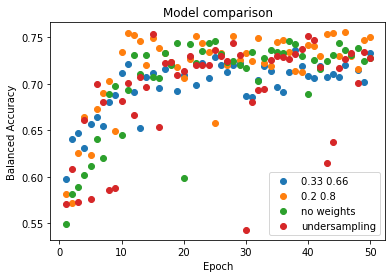

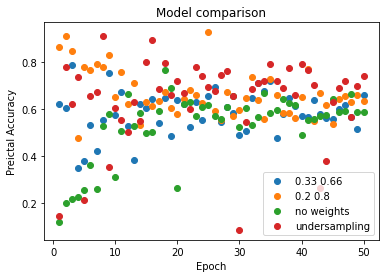

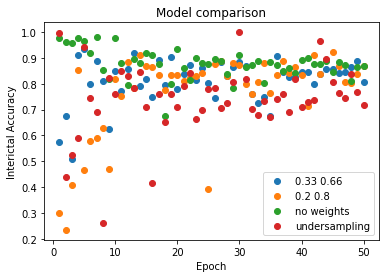

In [43]:
import matplotlib.pyplot as plt

epochs = np.arange(1,51)

plt.figure()
a=plt.scatter(epochs,acc_w1)
b=plt.scatter(epochs,acc_w2)
c=plt.scatter(epochs,acc_nw)
d=plt.scatter(epochs,acc_rus)
plt.legend((a,b,c,d),('0.33 0.66','0.2 0.8','no weights', 'undersampling'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Model comparison')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc_w1_pi)
b=plt.scatter(epochs,acc_w2_pi)
c=plt.scatter(epochs,acc_nw_pi)
d=plt.scatter(epochs,acc_rus_pi)
plt.legend((a,b,c,d),('0.33 0.66','0.2 0.8','no weights', 'undersampling'))
plt.xlabel('Epoch')
plt.ylabel('Preictal Accuracy')
plt.title('Model comparison')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc_w1_ii)
b=plt.scatter(epochs,acc_w2_ii)
c=plt.scatter(epochs,acc_nw_ii)
d=plt.scatter(epochs,acc_rus_ii)
plt.legend((a,b,c,d),('0.33 0.66','0.2 0.8','no weights', 'undersampling'))
plt.xlabel('Epoch')
plt.ylabel('Interictal Accuracy')
plt.title('Model comparison')
plt.show()

# Filters sizes inverted

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,5,padding=2)
    
    self.fc1 = nn.Linear(57600,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2)
    x = torch.flatten(x,start_dim=1)
    x=  F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x),dim=1)
    
    return x

device = torch.device('cuda')

In [ ]:
# Model with the filters sizes inverted

import random
import torch.optim as optim
import torch.tensor as tensor
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

batch_size = 32
epochs = 50

train = np.array(train)
y = np.array([int('preictal' in file) for file in train_files])

skf = StratifiedKFold(n_splits = 4, random_state = 0, shuffle = True)
split = 0

for train_idx, valid_idx in skf.split(train,y):

    split += 1

    net = Net()
    net.to(device)
    net = net.double()

    optimizer = optim.Adam(net.parameters(),lr=0.001)

    acc = []
    acc_pi = []
    acc_ii = []

    train_size = len(train_idx)
    batch_number = train_size//batch_size

    for epoch in range(epochs):

        start = time.time()

        random.shuffle(train_idx)
        batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
        count = 0

        for batch in batches:

            count += 1
            labels = tensor(y[batch]).to(device)
            n1 = torch.count_nonzero(labels)
            n0 = batch_size-n1
            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)

            net.zero_grad()
            output = net(x)
            loss = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
            loss.backward()
            optimizer.step()

            print('Epoch number %d/%d' % (epoch+1,epochs))
            print('Batch number %d/%d' % (count,batch_number))
            print('\n')

        with torch.no_grad():

            batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]

            pred = []

            for batch in batches:

                x = tensor(train[batch]).to(device)
                x = x.unsqueeze(1)

                pred.extend([int(i) for i in list(torch.argmax(net(x),dim=1))])

            valid_labels = list(y[valid_idx])[:len(pred)]
            valid_size = len(valid_labels)
            count0 = valid_labels.count(0)
            count1 = valid_labels.count(1)

            acc.append(balanced_accuracy_score(valid_labels,pred))
            acc_pi.append(sum([1 for i in range(valid_size) if pred[i]==1 and valid_labels[i]==1])/count1)
            acc_ii.append(sum([1 for i in range(valid_size) if pred[i]==0 and valid_labels[i]==0])/count0)

        end = time.time()
        print(end-start)
        print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_inv_v' + str(split) + '.npy',acc_w1)
np.save('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_preictal_inv_v' + str(split) + '.npy',acc_wpi1)
np.save('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_interictal_inv_v' + str(split) + '.npy',acc_wii1)

break 

In [45]:
acc_nw = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_no_weights_v1.npy').reshape(1,-1)
acc_nw_pi = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_preictal_no_weights_v1.npy').reshape(1,-1)
acc_nw_ii = np.load('/content/drive/MyDrive/attempts_accuracies/imbalance/acc_interictal_no_weights_v1.npy').reshape(1,-1)

In [46]:
acc_inv = np.load('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_inv_v1.npy').reshape(1,-1)
acc_inv_pi = np.load('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_preictal_inv_v1.npy').reshape(1,-1)
acc_inv_ii = np.load('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_interictal_inv_v1.npy').reshape(1,-1)

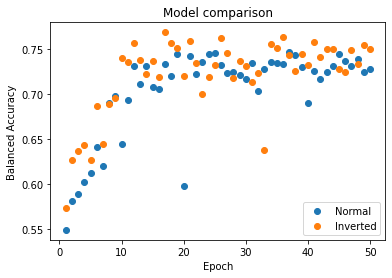

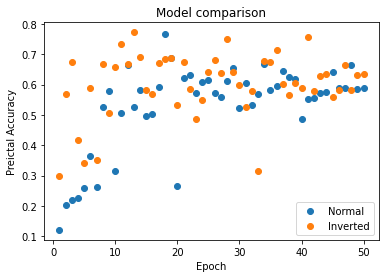

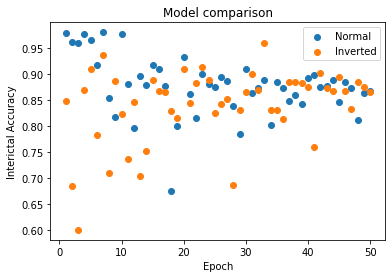

In [47]:
import matplotlib.pyplot as plt

epochs = np.arange(1,51)

plt.figure()
a=plt.scatter(epochs,acc_nw)
b=plt.scatter(epochs,acc_inv)
plt.legend((a,b),('Normal','Inverted'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Model comparison')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc_nw_pi)
b=plt.scatter(epochs,acc_inv_pi)
plt.legend((a,b),('Normal','Inverted'))
plt.xlabel('Epoch')
plt.ylabel('Preictal Accuracy')
plt.title('Model comparison')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc_nw_ii)
b=plt.scatter(epochs,acc_inv_ii)
plt.legend((a,b),('Normal','Inverted'))
plt.xlabel('Epoch')
plt.ylabel('Interictal Accuracy')
plt.title('Model comparison')
plt.show()

# 2 vs 3 linear layers

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,5,padding=2)

    self.fc1 = nn.Linear(57600,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2)
    x = torch.flatten(x,start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x),dim=1)
    
    return x

device = torch.device('cuda')

In [ ]:
# Model with 3 linear layers

import random
import numpy as np
import torch.optim as optim
import torch.tensor as tensor
import torch
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

batch_size = 32
epochs = 50

idx = []
for i in range(len(train)):
  idx.append(i)

train_idx, valid_idx = train_test_split(idx, test_size=0.25, random_state=0, shuffle=True)

train = np.array(train)
labels = [int('preictal' in file) for file in train_files]
y = np.array(labels)

net = Net()
net = net.double()
net.to(device)
    
optimizer = optim.Adam(net.parameters(),lr=0.001)

acc3 = []
acc3_pi = []
acc3_ii = []

train_size = len(train_idx)
batch_number = train_size//batch_size

for epoch in range(epochs):

    random.shuffle(train_idx)
    batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
    count = 0

    for batch in batches:

        start = time.time()
        count += 1
        labels = tensor(y[batch]).to(device)
        n1 = torch.count_nonzero(labels)
        n0 = batch_size-n1
        x = tensor(train[batch]).to(device)
        x = x.unsqueeze(1)

        net.zero_grad()
        output = net(x)
        loss = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss.backward()
        optimizer.step()
        print('Epoch number %d/%d' % (epoch+1,epochs))
        print('Batch number %d/%d' % (count,batch_number))
        print('Loss is %f' % (float(loss)))
        print('\n')
            
    with torch.no_grad():

        batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]

        pred = []

        for batch in batches:

            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)
            pred.extend([int(i) for i in list(torch.argmax(net(x),dim=1))])

        valid_labels = list(y[valid_idx])[:len(pred)]
        valid_size = len(valid_labels)
        count0 = valid_labels.count(0)
        count1 = valid_labels.count(1)

        acc3.append(balanced_accuracy_score(valid_labels,pred))
        acc3_pi.append(sum([1 for i in range(valid_size) if pred[i]==1 and valid_labels[i]==1])/count1)
        acc3_ii.append(sum([1 for i in range(valid_size) if pred[i]==0 and valid_labels[i]==0])/count0)

    end = time.time()
    print(end-start)
    print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/3_layers/acc3.npy',acc3)
np.save('/content/drive/MyDrive/attempts_accuracies/3_layers/acc3_pi.npy',acc3_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/3_layers/acc3_ii.npy',acc3_ii)

In [48]:
acc_inv = np.load('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_inv_v1.npy').reshape(1,-1)
acc_inv_pi = np.load('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_preictal_inv_v1.npy').reshape(1,-1)
acc_inv_ii = np.load('/content/drive/MyDrive/attempts_accuracies/filters_sizes/acc_interictal_inv_v1.npy').reshape(1,-1)

In [50]:
acc3 = np.load('/content/drive/MyDrive/attempts_accuracies/3_layers/acc3.npy').reshape(1,-1)
acc3_pi = np.load('/content/drive/MyDrive/attempts_accuracies/3_layers/acc3_pi.npy').reshape(1,-1)
acc3_ii = np.load('/content/drive/MyDrive/attempts_accuracies/3_layers/acc3_ii.npy').reshape(1,-1)

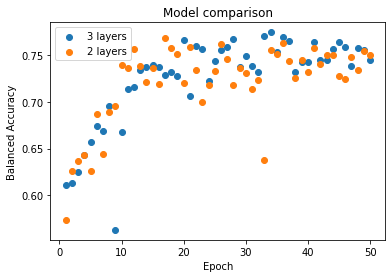

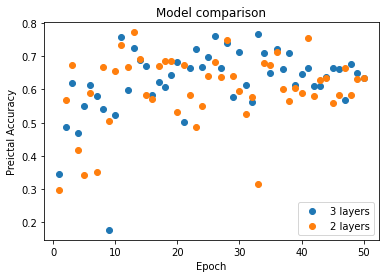

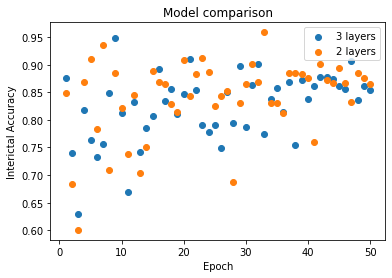

In [51]:
import matplotlib.pyplot as plt

epochs = np.arange(1,51)

plt.figure()
a=plt.scatter(epochs,acc3)
b=plt.scatter(epochs,acc_inv)
plt.legend((a,b),('3 layers','2 layers'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Model comparison')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc3_pi)
b=plt.scatter(epochs,acc_inv_pi)
plt.legend((a,b),('3 layers','2 layers'))
plt.xlabel('Epoch')
plt.ylabel('Preictal Accuracy')
plt.title('Model comparison')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc3_ii)
b=plt.scatter(epochs,acc_inv_ii)
plt.legend((a,b),('3 layers','2 layers'))
plt.xlabel('Epoch')
plt.ylabel('Interictal Accuracy')
plt.title('Model comparison')
plt.show()

# Check if under/overfitting with 3 layers

In [ ]:
# Model to see if there is underfitting or overfitting

import random
import numpy as np
import torch.optim as optim
import torch.tensor as tensor
import torch
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

batch_size = 32
epochs = 50

idx = []
for i in range(len(train)):
  idx.append(i)

train_idx, valid_idx = train_test_split(idx, test_size=0.25, random_state=0, shuffle=True)

train = np.array(train)
labels = [int('preictal' in file) for file in train_files]
y = np.array(labels)

net = Net()
net = net.double()
net.to(device)
    
optimizer = optim.Adam(net.parameters(),lr=0.001)

acc_train = []
acc_train_pi = []
acc_train_ii = []
acc_test = []
acc_test_pi = []
acc_test_ii = []

train_size = len(train_idx)
batch_number = train_size//batch_size

for epoch in range(epochs):

    random.shuffle(train_idx)
    batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
    count = 0

    for batch in batches:

        start = time.time()
        count += 1
        labels = tensor(y[batch]).to(device)
        n1 = torch.count_nonzero(labels)
        n0 = batch_size-n1
        x = tensor(train[batch]).to(device)
        x = x.unsqueeze(1)

        net.zero_grad()
        output = net(x)
        loss = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss.backward()
        optimizer.step()
        print('Epoch number %d/%d' % (epoch+1,epochs))
        print('Batch number %d/%d' % (count,batch_number))
        print('Loss is %f' % (float(loss)))
        print('\n')
            
    with torch.no_grad():

        # Training accuracy

        batches0 = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
        pred0 = []

        for batch in batches0:

            x0 = tensor(train[batch]).to(device)
            x0 = x0.unsqueeze(1)
            pred0.extend([int(i) for i in list(torch.argmax(net(x0),dim=1))])
        
        train_labels = list(y[train_idx])[:len(pred0)]
        train_size = len(train_labels)
        count0 = train_labels.count(0)
        count1 = train_labels.count(1)

        acc_train.append(balanced_accuracy_score(train_labels,pred0))
        acc_train_pi.append(sum([1 for i in range(train_size) if pred0[i]==1 and train_labels[i]==1])/count1)
        acc_train_ii.append(sum([1 for i in range(train_size) if pred0[i]==0 and train_labels[i]==0])/count0)

        # Testing accuracy

        batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]
        pred = []

        for batch in batches:

            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)
            pred.extend([int(i) for i in list(torch.argmax(net(x),dim=1))])

        valid_labels = list(y[valid_idx])[:len(pred)]
        valid_size = len(valid_labels)
        count0 = valid_labels.count(0)
        count1 = valid_labels.count(1)

        acc_test.append(balanced_accuracy_score(valid_labels,pred))
        acc_test_pi.append(sum([1 for i in range(valid_size) if pred[i]==1 and valid_labels[i]==1])/count1)
        acc_test_ii.append(sum([1 for i in range(valid_size) if pred[i]==0 and valid_labels[i]==0])/count0)

    end = time.time()
    print(end-start)
    print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/fitting/acc_train.npy',acc_train)
np.save('/content/drive/MyDrive/attempts_accuracies/fitting/acc_train_pi.npy',acc_train_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/fitting/acc_train_ii.npy',acc_train_ii)
np.save('/content/drive/MyDrive/attempts_accuracies/fitting/acc_test.npy',acc_test)
np.save('/content/drive/MyDrive/attempts_accuracies/fitting/acc_test_pi.npy',acc_test_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/fitting/acc_test_ii.npy',acc_test_ii)

In [53]:
acc_train = np.load('/content/drive/MyDrive/attempts_accuracies/fitting/acc_train.npy').reshape(1,-1)
acc_train_pi = np.load('/content/drive/MyDrive/attempts_accuracies/fitting/acc_train_pi.npy').reshape(1,-1)
acc_train_ii = np.load('/content/drive/MyDrive/attempts_accuracies/fitting/acc_train_ii.npy').reshape(1,-1)

In [54]:
acc_test = np.load('/content/drive/MyDrive/attempts_accuracies/fitting/acc_test.npy').reshape(1,-1)
acc_test_pi = np.load('/content/drive/MyDrive/attempts_accuracies/fitting/acc_test_pi.npy').reshape(1,-1)
acc_test_ii = np.load('/content/drive/MyDrive/attempts_accuracies/fitting/acc_test_ii.npy').reshape(1,-1)

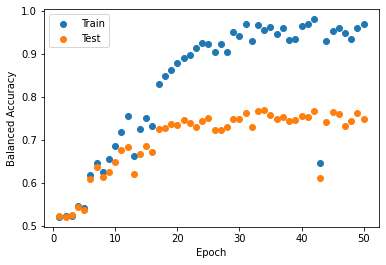

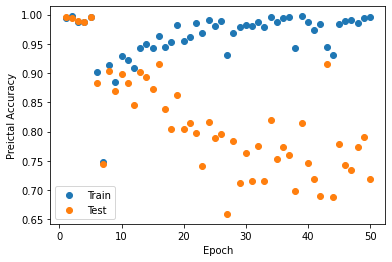

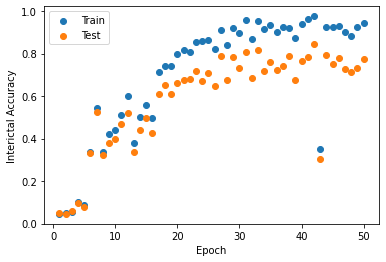

In [56]:
import matplotlib.pyplot as plt

epochs = np.arange(1,51)

plt.figure()
a=plt.scatter(epochs,acc_train)
b=plt.scatter(epochs,acc_test)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc_train_pi)
b=plt.scatter(epochs,acc_test_pi)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Preictal Accuracy')
plt.show()

plt.figure()
a=plt.scatter(epochs,acc_train_ii)
b=plt.scatter(epochs,acc_test_ii)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Interictal Accuracy')
plt.show()

# Dropout

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net01(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,5,padding=2)

    self.fc1 = nn.Linear(57600,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)
    self.dropout = nn.Dropout(0.1) 
    self.dropout2d = nn.Dropout2d(0.1) 

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = self.dropout2d(F.max_pool2d(x,2))
    x = F.relu(self.conv2(x))
    x = self.dropout2d(F.max_pool2d(x,2))
    x = F.relu(self.conv3(x))
    x = self.dropout2d(F.max_pool2d(x,2))    
    x = torch.flatten(x,start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x),dim=1)
    
    return x

device = torch.device('cuda')

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net03(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,5,padding=2)

    self.fc1 = nn.Linear(57600,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)
    self.dropout = nn.Dropout(0.3) 
    self.dropout2d = nn.Dropout2d(0.3) 

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = self.dropout2d(F.max_pool2d(x,2))
    x = F.relu(self.conv2(x))
    x = self.dropout2d(F.max_pool2d(x,2))
    x = F.relu(self.conv3(x))
    x = self.dropout2d(F.max_pool2d(x,2))    
    x = torch.flatten(x,start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x),dim=1)
    
    return x

device = torch.device('cuda')

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net05(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,5,padding=2)

    self.fc1 = nn.Linear(57600,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)
    self.dropout = nn.Dropout(0.5) 
    self.dropout2d = nn.Dropout2d(0.5) 

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = self.dropout2d(F.max_pool2d(x,2))
    x = F.relu(self.conv2(x))
    x = self.dropout2d(F.max_pool2d(x,2))
    x = F.relu(self.conv3(x))
    x = self.dropout2d(F.max_pool2d(x,2))    
    x = torch.flatten(x,start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x),dim=1)
    
    return x

device = torch.device('cuda')

In [ ]:
import random
import numpy as np
import torch.optim as optim
import torch.tensor as tensor
import torch
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

batch_size = 32
epochs = 100

idx = []
for i in range(len(train)):
  idx.append(i)

train_idx, valid_idx = train_test_split(idx, test_size=0.25, random_state=0, shuffle=True)

train = np.array(train)
labels = [int('preictal' in file) for file in train_files]
y = np.array(labels)

net01 = Net01()
net01 = net01.double()
net01.to(device)

net03 = Net03()
net03 = net03.double()
net03.to(device)

net05 = Net05()
net05 = net05.double()
net05.to(device)
    
optimizer01 = optim.Adam(net01.parameters(),lr=0.001)
optimizer03 = optim.Adam(net03.parameters(),lr=0.001)
optimizer05 = optim.Adam(net05.parameters(),lr=0.001)

acc01_train = []
acc01_train_pi = []
acc01_train_ii = []
acc01_test = []
acc01_test_pi = []
acc01_test_ii = []

acc03_train = []
acc03_train_pi = []
acc03_train_ii = []
acc03_test = []
acc03_test_pi = []
acc03_test_ii = []

acc05_train = []
acc05_train_pi = []
acc05_train_ii = []
acc05_test = []
acc05_test_pi = []
acc05_test_ii = []

train_size = len(train_idx)
batch_number = train_size//batch_size

for epoch in range(epochs):

    random.shuffle(train_idx)
    batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
    count = 0

    for batch in batches:

        start = time.time()
        count += 1
        labels = tensor(y[batch]).to(device)
        n1 = torch.count_nonzero(labels)
        n0 = batch_size-n1
        x = tensor(train[batch]).to(device)
        x = x.unsqueeze(1)

        net01.zero_grad()
        output = net01(x)
        loss01 = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss01.backward()
        optimizer01.step()

        net03.zero_grad()
        output = net03(x)
        loss03 = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss03.backward()
        optimizer03.step()

        net05.zero_grad()
        output = net05(x)
        loss05 = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss05.backward()
        optimizer05.step()

        print('Epoch number %d/%d' % (epoch+1,epochs))
        print('Batch number %d/%d' % (count,batch_number))
        print('Loss 01 is %f' % (float(loss01)))
        print('Loss 03 is %f' % (float(loss03)))
        print('Loss 05 is %f' % (float(loss05)))
        print('\n')
            
    with torch.no_grad():

        # Training accuracy

        batches0 = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
        pred01 = []
        pred03 = []
        pred05 = []

        for batch in batches0:

            x0 = tensor(train[batch]).to(device)
            x0 = x0.unsqueeze(1)
            pred01.extend([int(i) for i in list(torch.argmax(net01(x0),dim=1))])
            pred03.extend([int(i) for i in list(torch.argmax(net03(x0),dim=1))])
            pred05.extend([int(i) for i in list(torch.argmax(net05(x0),dim=1))])
        
        train_labels = list(y[train_idx])[:len(pred01)]
        train_size = len(train_labels)
        count0 = train_labels.count(0)
        count1 = train_labels.count(1)
        acc01_train.append(balanced_accuracy_score(train_labels,pred01))
        acc01_train_pi.append(sum([1 for i in range(train_size) if pred01[i]==1 and train_labels[i]==1])/count1)
        acc01_train_ii.append(sum([1 for i in range(train_size) if pred01[i]==0 and train_labels[i]==0])/count0)

        train_labels = list(y[train_idx])[:len(pred03)]
        train_size = len(train_labels)
        count0 = train_labels.count(0)
        count1 = train_labels.count(1)
        acc03_train.append(balanced_accuracy_score(train_labels,pred03))
        acc03_train_pi.append(sum([1 for i in range(train_size) if pred03[i]==1 and train_labels[i]==1])/count1)
        acc03_train_ii.append(sum([1 for i in range(train_size) if pred03[i]==0 and train_labels[i]==0])/count0)

        train_labels = list(y[train_idx])[:len(pred05)]
        train_size = len(train_labels)
        count0 = train_labels.count(0)
        count1 = train_labels.count(1)
        acc05_train.append(balanced_accuracy_score(train_labels,pred05))
        acc05_train_pi.append(sum([1 for i in range(train_size) if pred05[i]==1 and train_labels[i]==1])/count1)
        acc05_train_ii.append(sum([1 for i in range(train_size) if pred05[i]==0 and train_labels[i]==0])/count0)

        # Testing accuracy

        batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]
        pred01 = []
        pred03 = []
        pred05 = []

        for batch in batches:

            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)
            pred01.extend([int(i) for i in list(torch.argmax(net01(x),dim=1))])
            pred03.extend([int(i) for i in list(torch.argmax(net03(x),dim=1))])
            pred05.extend([int(i) for i in list(torch.argmax(net05(x),dim=1))])

        valid_labels = list(y[valid_idx])[:len(pred01)]
        valid_size = len(valid_labels)
        count0 = valid_labels.count(0)
        count1 = valid_labels.count(1)
        acc01_test.append(balanced_accuracy_score(valid_labels,pred01))
        acc01_test_pi.append(sum([1 for i in range(valid_size) if pred01[i]==1 and valid_labels[i]==1])/count1)
        acc01_test_ii.append(sum([1 for i in range(valid_size) if pred01[i]==0 and valid_labels[i]==0])/count0)

        valid_labels = list(y[valid_idx])[:len(pred03)]
        valid_size = len(valid_labels)
        count0 = valid_labels.count(0)
        count1 = valid_labels.count(1)
        acc03_test.append(balanced_accuracy_score(valid_labels,pred03))
        acc03_test_pi.append(sum([1 for i in range(valid_size) if pred03[i]==1 and valid_labels[i]==1])/count1)
        acc03_test_ii.append(sum([1 for i in range(valid_size) if pred03[i]==0 and valid_labels[i]==0])/count0)

        valid_labels = list(y[valid_idx])[:len(pred05)]
        valid_size = len(valid_labels)
        count0 = valid_labels.count(0)
        count1 = valid_labels.count(1)
        acc05_test.append(balanced_accuracy_score(valid_labels,pred01))
        acc05_test_pi.append(sum([1 for i in range(valid_size) if pred05[i]==1 and valid_labels[i]==1])/count1)
        acc05_test_ii.append(sum([1 for i in range(valid_size) if pred05[i]==0 and valid_labels[i]==0])/count0)

    end = time.time()
    print(end-start)
    print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_train.npy',acc01_train)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_train_pi.npy',acc01_train_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_train_ii.npy',acc01_train_ii)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_test.npy',acc01_test)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_test_pi.npy',acc01_test_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_test_ii.npy',acc01_test_ii)

np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_train.npy',acc03_train)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_train_pi.npy',acc03_train_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_train_ii.npy',acc03_train_ii)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_test.npy',acc03_test)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_test_pi.npy',acc03_test_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_test_ii.npy',acc03_test_ii)

np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_train.npy',acc05_train)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_train_pi.npy',acc05_train_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_train_ii.npy',acc05_train_ii)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_test.npy',acc05_test)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_test_pi.npy',acc05_test_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_test_ii.npy',acc05_test_ii)

In [57]:
acc01_train = np.load('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_train.npy')
acc01_test = np.load('/content/drive/MyDrive/attempts_accuracies/dropout/dropout01/acc01_test.npy')

acc03_train = np.load('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_train.npy')
acc03_test = np.load('/content/drive/MyDrive/attempts_accuracies/dropout/dropout03/acc03_test.npy')

acc05_train = np.load('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_train.npy')
acc05_test = np.load('/content/drive/MyDrive/attempts_accuracies/dropout/dropout05/acc05_test.npy')

[]

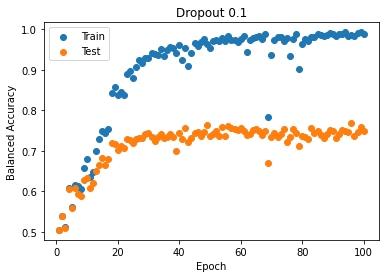

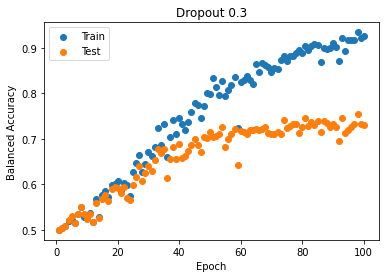

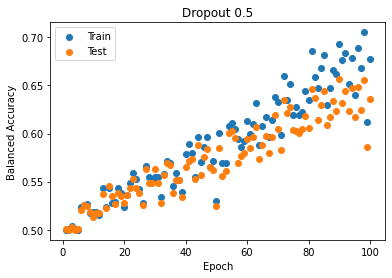

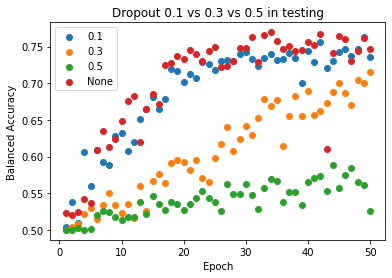

In [62]:
import matplotlib.pyplot as plt

epochs = np.arange(1,101)

plt.figure()
a=plt.scatter(epochs,acc01_train)
b=plt.scatter(epochs,acc01_test)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Dropout 0.1')
plt.plot()

plt.figure()
a=plt.scatter(epochs,acc03_train)
b=plt.scatter(epochs,acc03_test)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Dropout 0.3')
plt.plot()

plt.figure()
a=plt.scatter(epochs,acc05_train)
b=plt.scatter(epochs,acc05_test)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Dropout 0.5')
plt.plot()

plt.figure()
a=plt.scatter(epochs[:50],acc01_test[:50])
b=plt.scatter(epochs[:50],acc03_test[:50])
c=plt.scatter(epochs[:50],acc05_test[:50])
d=plt.scatter(epochs[:50],acc_test)
plt.legend((a,b,c,d),('0.1','0.3','0.5','None'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Dropout 0.1 vs 0.3 vs 0.5 in testing')
plt.plot()

# L2 regularization

In [ ]:
# Weight decay 1e-2

import random
import numpy as np
import torch.optim as optim
import torch.tensor as tensor
import torch
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

batch_size = 32
epochs = 100

idx = []
for i in range(len(train)):
  idx.append(i)

train_idx, valid_idx = train_test_split(idx, test_size=0.25, random_state=0, shuffle=True)

train = np.array(train)
labels = [int('preictal' in file) for file in train_files]
y = np.array(labels)

net = Net()
net = net.double()
net.to(device)
    
optimizer = optim.Adam(net.parameters(),lr=1e-4, weight_decay=1e-2)

accL2Weightv3_train = []
accL2Weightv3_train_pi = []
accL2Weightv3_train_ii = []
accL2Weightv3_test = []
accL2Weightv3_test_pi = []
accL2Weightv3_test_ii = []

train_size = len(train_idx)
batch_number = train_size//batch_size

for epoch in range(epochs):

    random.shuffle(train_idx)
    batches = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
    count = 0

    for batch in batches:

        start = time.time()
        count += 1
        labels = tensor(y[batch]).to(device)
        n1 = torch.count_nonzero(labels)
        n0 = batch_size-n1
        x = tensor(train[batch]).to(device)
        x = x.unsqueeze(1)

        net.zero_grad()
        output = net(x)
        loss = F.nll_loss(output,labels,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss.backward()
        optimizer.step()
        print('Epoch number %d/%d' % (epoch+1,epochs))
        print('Batch number %d/%d' % (count,batch_number))
        print('Loss is %f' % (float(loss)))
        print('\n')
            
    with torch.no_grad():

        # Training accuracy

        batches0 = [train_idx[i:i+batch_size] for i in range(0,len(train_idx)-batch_size,batch_size)]
        pred0 = []

        for batch in batches0:

            x0 = tensor(train[batch]).to(device)
            x0 = x0.unsqueeze(1)
            pred0.extend([int(i) for i in list(torch.argmax(net(x0),dim=1))])
        
        train_labels = list(y[train_idx])[:len(pred0)]
        train_size = len(train_labels)
        count0 = train_labels.count(0)
        count1 = train_labels.count(1)

        accL2Weightv3_train.append(balanced_accuracy_score(train_labels,pred0))
        accL2Weightv3_train_pi.append(sum([1 for i in range(train_size) if pred0[i]==1 and train_labels[i]==1])/count1)
        accL2Weightv3_train_ii.append(sum([1 for i in range(train_size) if pred0[i]==0 and train_labels[i]==0])/count0)

        # Testing accuracy

        batches = [valid_idx[i:i+batch_size] for i in range(0,len(valid_idx)-batch_size,batch_size)]
        pred = []

        for batch in batches:

            x = tensor(train[batch]).to(device)
            x = x.unsqueeze(1)
            pred.extend([int(i) for i in list(torch.argmax(net(x),dim=1))])

        valid_labels = list(y[valid_idx])[:len(pred)]
        valid_size = len(valid_labels)
        count0 = valid_labels.count(0)
        count1 = valid_labels.count(1)

        accL2Weightv3_test.append(balanced_accuracy_score(valid_labels,pred))
        accL2Weightv3_test_pi.append(sum([1 for i in range(valid_size) if pred[i]==1 and valid_labels[i]==1])/count1)
        accL2Weightv3_test_ii.append(sum([1 for i in range(valid_size) if pred[i]==0 and valid_labels[i]==0])/count0)

    end = time.time()
    print(end-start)
    print('\n')

np.save('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_train.npy',accL2Weightv3_train)
np.save('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_train_pi.npy',accL2Weightv3_train_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_train_ii.npy',accL2Weightv3_train_ii)
np.save('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_test.npy',accL2Weightv3_test)
np.save('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_test_pi.npy',accL2Weightv3_test_pi)
np.save('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_test_ii.npy',accL2Weightv3_test_ii)

In [66]:
accL2Weightv3_train = np.load('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_train.npy')
accL2Weightv3_train_pi = np.load('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_train_pi.npy')
accL2Weightv3_train_ii = np.load('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_train_ii.npy')
accL2Weightv3_test = np.load('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_test.npy')
accL2Weightv3_test_pi = np.load('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_test_pi.npy')
accL2Weightv3_test_ii = np.load('/content/drive/MyDrive/attempts_accuracies/L2/accL2Weightv3_test_ii.npy')

[]

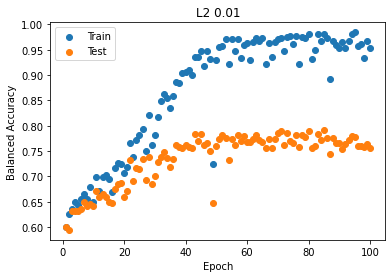

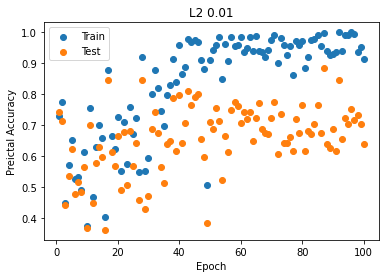

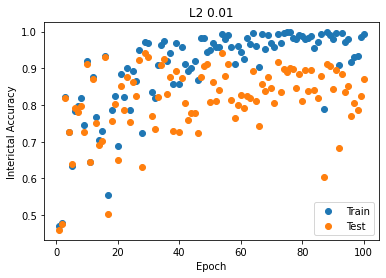

In [67]:
import matplotlib.pyplot as plt

epochs = []
for i in range(len(accL2Weightv3_train)):
  epochs.append(i+1)

plt.figure()
a=plt.scatter(epochs,accL2Weightv3_train)
b=plt.scatter(epochs,accL2Weightv3_test)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('L2 0.01')
plt.plot()

plt.figure()
a=plt.scatter(epochs,accL2Weightv3_train_pi)
b=plt.scatter(epochs,accL2Weightv3_test_pi)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Preictal Accuracy')
plt.title('L2 0.01')
plt.plot()

plt.figure()
a=plt.scatter(epochs,accL2Weightv3_train_ii)
b=plt.scatter(epochs,accL2Weightv3_test_ii)
plt.legend((a,b),('Train','Test'))
plt.xlabel('Epoch')
plt.ylabel('Interictal Accuracy')
plt.title('L2 0.01')
plt.plot()